<a href="https://colab.research.google.com/github/maxmatical/fast.ai/blob/master/fastai_v3_lesson3_imdb_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMDB

In [0]:
# Set up environment and download course-v3
!curl -s https://course.fast.ai/setup/colab | bash


In [0]:
from fastai import *
from fastai.text import *
from fastai.utils.show_install import *
show_install()

# Full IMDB Data

In [0]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/content/data/imdb/models'),
 PosixPath('/content/data/imdb/unsup'),
 PosixPath('/content/data/imdb/tmp_clas'),
 PosixPath('/content/data/imdb/README'),
 PosixPath('/content/data/imdb/train'),
 PosixPath('/content/data/imdb/test'),
 PosixPath('/content/data/imdb/tmp_lm'),
 PosixPath('/content/data/imdb/imdb.vocab')]

In [0]:
(path/'train').ls()

[PosixPath('/content/data/imdb/train/unsupBow.feat'),
 PosixPath('/content/data/imdb/train/neg'),
 PosixPath('/content/data/imdb/train/labeledBow.feat'),
 PosixPath('/content/data/imdb/train/pos')]

The reviews are in a training and test set following an imagenet structure. The only difference is that there is an `unsup` folder in `train` that contains the unlabelled data.

## Language model

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipeia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reviex lefts by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust a little bit the parameters of our model. Plus there might be some words extremely common in that dataset that were barely present in wikipedia, and therefore might no be part of the vocabulary the model was trained on.

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

In [0]:
bs=32

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (next line takes a few minutes).

In [0]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
           # We use both the train and text data to build our LM
            .filter_by_folder(include=['train', 'test']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .random_split_by_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs= bs,))


# change num workers if needed




# data_lm.save('tmp_lm')

We have to use a special kind of `TextDataBunch` for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

The line before being a bit long, we want to load quickly the final ids by using the following cell.

In [0]:
# data_lm = TextLMDataBunch.load(path, 'tmp_lm', bs=bs)

In [0]:
data_lm.show_batch()

idx,text
0,"marseilles , asks for some names , beats up some people , gets the names , goes to more scuzzy places , asks for more names , beats up more people , etc . xxmaj the whole movie is punch after punch after punch . xxmaj it seems that the people who made it had no other ambition than to create the xxmaj french equivalent of "" xxmaj dirty xxmaj"
1,"appeared engaged was when she was interacting with xxmaj matt xxmaj dillon , who i thought was appropriately over the top as xxmaj evil xxmaj bad xxmaj guy xxmaj trip xxmaj murphy . \n \n xxmaj it was great to see xxmaj herbie again , and i loved the movie intro with material from the old movies . xxmaj if xxmaj disney had popped out with some xxmaj car"
2,time . xxbos xxmaj who in their right mind does anything so stupid as this movie ? \n \n xxmaj accidental killing of a security guard ... characters that are so two dimensional that a two year old could have painted drawn them ... and better ... \n \n a red toolbox of death ? xxmaj please xxrep 4 . \n \n xxmaj xxunk weak thugs ...
3,"to wonder just what the heck this thing is about ! the title premise could have been the basis for a fun ( if politically incorrect ) comedy . instead , we 're treated to cheap , amateurish , unfinished sketches and depravity and weirdness for its own sake . if i want that , i 'll go buy a grace jones cd . xxbos i am a huge ,"
4,"like too often the case in other contemporary witchcraft movies like "" xxmaj the xxmaj dunwich xxmaj horror "" and "" xxmaj the xxmaj xxunk xxmaj terror "" . xxmaj the film jumps back and forth between the events in present day and flashbacks of 1692 ; which keeps it rather amusing and fast - paced . xxmaj the xxmaj ann xxmaj putman girl is quite a fascinating character ,"


We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in './fastai/models/' (or elsewhere if you specified different paths in your config file).

In [0]:
# ??language_model_learner

try 

FlattenedLoss(LabelSmoothingCrossEntropy, axis=-1)


In [0]:
# learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.3).to_fp16()


learn = language_model_learner(data_lm, arch=AWD_LSTM, loss_func = FlattenedLoss(LabelSmoothingCrossEntropy, axis=-1),
                               drop_mult=0.3).to_fp16()



drop_mult is multiplied to the default dropout rate

if drop_mult = 1, use default dropout rate

if drop_mult = 0.5, use default dropout rate * 0.5

higher drop_mult -> higher droput rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


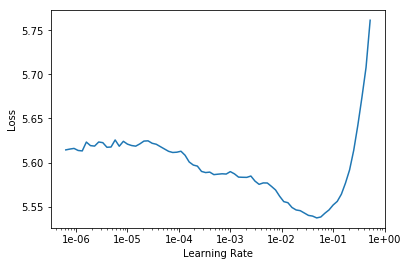

In [0]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

just training the last layer (all other layers are frozen)

epoch,train_loss,valid_loss,accuracy,time
0,5.113927,4.988869,0.292919,1:09:04


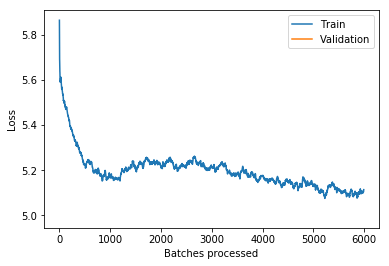

In [0]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

learn.recorder.plot_losses()

# moms is the momentum
# useful for rnns to decrease the momentums a bit to get better results

fp16: around 28% accuracy

with label smoothing: around 29% accuracy

In [0]:
learn.save('fit_head')

In [0]:
learn.load('fit_head');

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [0]:
learn.unfreeze()
#learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))
learn.fit_one_cycle(1, slice(1e-2/(2.6**4), 1e-2), moms=(0.8,0.7))

learn.recorder.plot_losses()


epoch,train_loss,valid_loss,accuracy,time


since accuracy isn't dropping yet, we haven't overfitted yet, so we can probably continue training the model more

In [0]:
learn.fit_one_cycle(1, slice(1e-2/(2.6**4), 1e-2), moms=(0.8,0.7))

learn.recorder.plot_losses()

In [0]:
learn.save('fine_tuned')

How good is our model? Well let's try to see what it predicts after a few given words.

In [0]:
learn.load('fine_tuned');

In [0]:
learn.predict('I liked this movie because ', 100, temperature=1.1, min_p=0.001)

'I liked this movie because  at other make do see the , the but any that . but so Was it , Not movie of . . of from and with are the are with Movies . for a to : . . ( of bad me it It get to of the It not movie to so in \n \n  to me The , a film Was would really : a been \n \n  movie you " , on some , could " to is be n\'t to for A and for not be is of an to'

We have to save the model but also its **encoder, **the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [0]:
learn.save_encoder('fine_tuned_enc')

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [0]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/home/jhoward/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/jhoward/.fastai/data/imdb/models'),
 PosixPath('/home/jhoward/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/jhoward/.fastai/data/imdb/train'),
 PosixPath('/home/jhoward/.fastai/data/imdb/test'),
 PosixPath('/home/jhoward/.fastai/data/imdb/README'),
 PosixPath('/home/jhoward/.fastai/data/imdb/tmp_clas')]

In [0]:
(path/'train').ls()

[PosixPath('/home/jhoward/.fastai/data/imdb/train/pos'),
 PosixPath('/home/jhoward/.fastai/data/imdb/train/unsup'),
 PosixPath('/home/jhoward/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/home/jhoward/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/home/jhoward/.fastai/data/imdb/train/neg')]

In [0]:
bs = 32

data_clas = (TextList.from_folder(path, vocab=data_lm.vocab) # we need to ensure the vocab between the classifier and the LM is the same
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #remove docs with labels not in above list (i.e. 'unsup')
             .filter_missing_y()
             #label them all with their folders
             .databunch(bs=bs))
data_clas.save('tmp_clas')

In [0]:
len(data_clas.train_ds)

75000

In [0]:
data_clas = TextClasDataBunch.load(path, 'tmp_clas', bs=bs)
data_clas.show_batch()

text,label
"xxfld 1 match 1 : tag team table match bubba ray and spike dudley vs eddie guerrero and chris benoit bubba ray and spike dudley started things off with a tag team table match against eddie guerrero and chris benoit . according to the rules of the match , both",pos
"xxfld 1 i have never seen any of spike lee 's prior films , as their trailers never caught my interest . i have seen , and admire denzel washington , and jodie foster 's work , and have several of their dvds . i was , however , entirely",neg
"xxfld 1 pier paolo pasolini , or pee - pee - pee as i prefer to call him ( due to his love of showing male genitals ) , is perhaps xxup the most overrated european marxist director - and they are thick on the ground . how anyone can",neg
"xxfld 1 chris rock deserves better than he gives himself in "" down to earth . "" as directed by brothers chris & paul weitz of "" american pie "" fame , this uninspired remake of warren beatty 's 1978 fantasy "" heaven can wait , "" itself a rehash",neg
"xxfld 1 yesterday , i went to the monthly antique flea market that comes to town . i really have no interest in such things , but i went for the fellowship of friends who do have such an interest . looking over the hundreds of vendor , passing many",pos


We can then create a model to classify those reviews and load the encoder we saved before.

In [0]:
learn = text_classifier_learner(data_clas, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')
learn.freeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


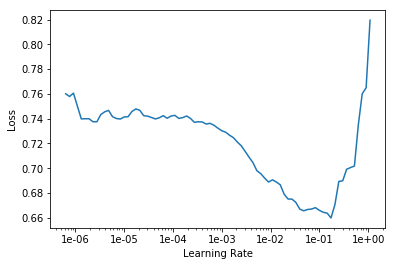

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

Total time: 02:46
epoch  train_loss  valid_loss  accuracy
1      0.294225    0.210385    0.918960  (02:46)



In [0]:
learn.save('first')

In [0]:
learn.load('first');

In [0]:
learn.freeze_to(-2) # only unfreezes the last 2 layers



learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

Total time: 03:03
epoch  train_loss  valid_loss  accuracy
1      0.268781    0.180993    0.930760  (03:03)



In [0]:
learn.save('second')

In [0]:
learn.load('second');

In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

Total time: 04:06
epoch  train_loss  valid_loss  accuracy
1      0.211133    0.161494    0.941280  (04:06)



In [0]:
learn.save('third')

In [0]:
learn.load('third');

In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

Total time: 10:01
epoch  train_loss  valid_loss  accuracy
1      0.188145    0.155038    0.942480  (05:00)
2      0.159475    0.153531    0.944040  (05:01)



In [0]:
learn.predict("I really loved that movie, it was awesome!")

('pos', tensor(0), tensor([[9.9999e-01, 1.1991e-05]]))

## Why do we do lr = slice(lr/(2.6**4), lr)??

the 2.6 value comes from results done by lots of model testing
- get a bunch of models with different hyperparameters, and their results
- use the hyperparameter settings as feature, results as label, put through a random forest
- use rf interpretation methods to get what are the optimal hyperparameter settings

That's where 2.6 comes from 

Using random forest interpretations can be useful for NN hyperparam optimization